# Contour Extraction

In [1]:
import pydicom as dcm
import numpy as np
from matplotlib import pyplot as plt
import os
import struct
import cv2

#### First set the output frame size and define the path to our DICOM files

In [179]:
%matplotlib inline    
plt.rcParams['figure.figsize']=(7,7)
PATH = "C:/Users/Maxwell/Desktop/Pat2"

#### Defining Important Fucntions

In [224]:
def extract_crop(img,contour):
    cnt = np.array(contour,np.int32) #extract contour data [[x1,y1],[x2,y2],...]
    bdRct=cv2.boundingRect(cnt) #set bounding rectangle for region of interest
    cropped = img[bdRct[1]:bdRct[1]+bdRct[3],bdRct[0]:bdRct[0]+bdRct[2]].copy() #crop 'img' using bounding rectangle
    shftCntPts = cnt - cnt.min(axis=0)#shift the contour points to points in cropped 'img'
    
    msk = np.zeros(cropped.shape) #initialize zeros
    cv2.drawContours(msk,[shftCntPts],-1,1,thickness=cv2.FILLED,lineType=cv2.LINE_AA) #generate mask
    mskCrop = cropped*msk #apply mask onto cropped image

    return mskCrop    

In [214]:
def readGraphicAnnotationSequence(dcmFile):
    #if ("GraphicAnnotationSequence" in sliceDcm): #if 'GraphicAnnotationSequence' attribute exists in DICOM slice
    #    print("Attribute Here!!!")
    return None

In [207]:
def readCurveData(dcmFile):
        
    if "CurveData"  not in sliceDcm.dir():
        return None
    
    #assuming >1 curve data exists
    
    curveLst=[]
    
    i = 0
    while (0x5000+(i*2),0x3000) in sliceDcm:
        contourBytes = sliceDcm[0x5000+(i*2),0x3000].value #get OD bytestream
        #more info see mxtsai.github.io/sheba.html > Preprocessing (password:  rsch  )
        
        conLen = (sliceDcm[0x5000+(i*2),0x0010].value)*2 #(x,y) counted a pair but need account both individually
        contXY = struct.unpack('f'*conLen,contourBytes) #the contour array in [x1,y1,x2,y2,...] format

        cnt = np.array([(int(contXY[i]),int(contXY[i+1])) for i in range(0,len(contXY),2)]) #organized contour array for cropping
        
        curveLst.append(cnt)
        i+=2
    
    return curveLst

#### Loop through all images in a DICOM folder

In [229]:
contourSet = [] #list to hold dicom layers
scanInfo = {} #dictionary to hold current scan's info 

for filename in os.listdir(PATH): #going thru each slice in PATH folder
    
    sliceDcm = dcm.dcmread(PATH+"/"+filename,force=True) #reading slice into pydicom
    
    slicePixel = sliceDcm.pixel_array #obtain pixel info of current slice
    
    if not scanInfo: #if the current scan's info is not recorded
        scanInfo["ID"] = sliceDcm.PatientID
        
    sliceOut = readCurveData(sliceDcm) #a list of curve datas if any
    
    if sliceOut != None:
        #there is a contour in this slice
        
        #will be problem here if 2 slices
        #will solve in future
        for curve in sliceOut: #each curve in a dicom slice
            crp=extract_crop(slicePixel,curve)
            contourSet.append(crp)
        

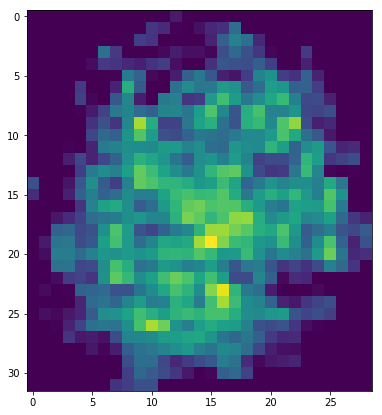

In [233]:
plt.imshow(contourSet[1])